In [43]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
# Analyze reliability, bandwidth, energy
data = []
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([0])
          ivddio = np.array([0])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                for i in range(65535):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_pba_3362
1bpc_bwa_0_conservative
1bpc_bwa_0
1bpc_bwa_3363
2bpc_pba_4633
2bpc_pba_4631
2bpc_pba_4885
2bpc_pba_4472


,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_0_conservative_cb,1,1,0.5160093307495117,0.515768,0.006558,1.228813e-09,2.302594e-16,5.336647e+06,0.500430,...,0.707411,65536,2312324,327680,65536,65535,51576770,4128790,1354688,957636
1,1bpc_bwa_0_conservative_cb,2,1,0.7442476749420166,0.744040,0.006606,1.785693e-09,4.827034e-16,3.699359e+06,0.505743,...,0.711156,65536,1372128,458751,131072,79843,74403981,7502749,2722322,961439
2,1bpc_bwa_0_conservative_cb,4,1,1.0624709129333496,1.062321,0.006661,2.570795e-09,9.922034e-16,2.590996e+06,0.373760,...,0.611359,65536,1184812,619464,262142,109600,106232109,10227655,5222592,1002119
3,1bpc_bwa_0_conservative_cb,8,1,1.5522022247314453,1.552022,0.006673,3.762625e-09,2.121614e-15,1.773473e+06,0.171707,...,0.414375,65536,15327,886700,402263,172082,155202224,13632476,6033117,1070268
4,1bpc_bwa_0_conservative_cb,16,1,1.782534122467041,1.782160,0.006668,4.317103e-09,2.795224e-15,1.544457e+06,0.177977,...,0.421873,65536,15316,1002934,393315,297255,178216011,13745375,5865781,1350572
5,1bpc_bwa_0_conservative_cb,32,1,2.281395196914673,2.281258,0.006706,5.557700e-09,4.606244e-15,1.206558e+06,0.176705,...,0.420363,65536,15471,1254956,394198,548549,228125822,13997607,5865356,1606798
6,1bpc_bwa_0_conservative_cb,64,1,3.262115240097046,3.261938,0.006718,7.960939e-09,9.434468e-15,8.438144e+05,0.177976,...,0.421872,65536,15390,1750274,395711,1042272,326193780,14447042,5849770,2069936
7,1bpc_bwa_0_conservative_cb,128,1,5.216239929199219,5.215984,0.006721,1.273574e-08,2.413446e-14,5.276991e+05,0.180188,...,0.424486,65536,15338,2737182,396110,2028729,521598392,15340416,5809987,3001895
8,1bpc_bwa_0_conservative_cb,256,1,9.096040725708008,9.095748,0.006741,2.227668e-08,7.361499e-14,3.026106e+05,0.181443,...,0.425961,65536,15221,4696695,398048,3986187,909574829,17268633,5801930,4935478
9,1bpc_bwa_0_conservative_cb,512,1,16.8013699054718,16.800860,0.006735,4.111103e-08,2.509385e-13,1.638291e+05,0.183431,...,0.428289,65536,15112,8588199,399003,7876627,1680085972,21092732,5780299,8778701


/tmp/ipykernel_233945/2572852257.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale("log")


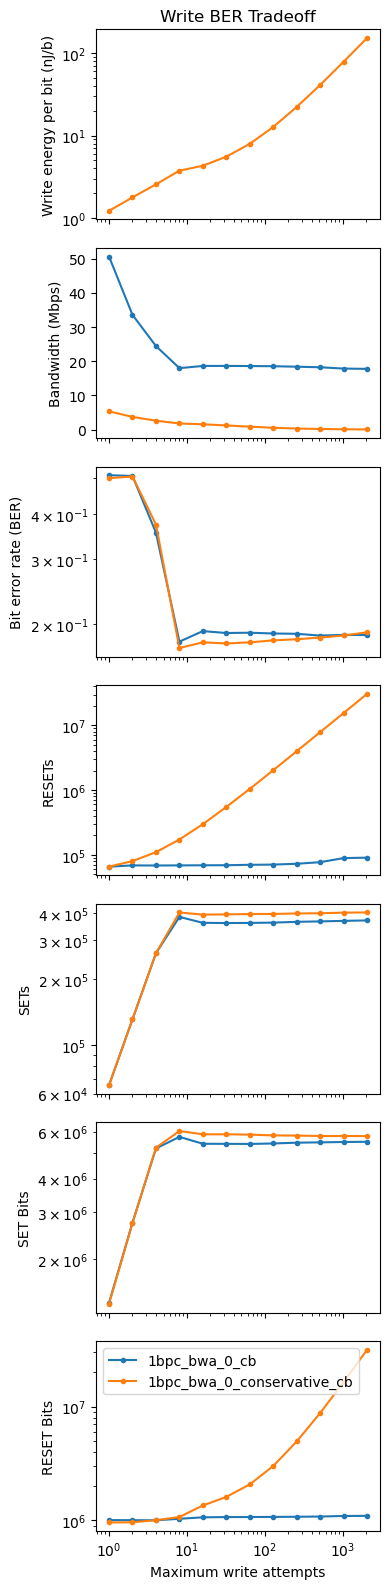

In [45]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  axs[1].set_ylabel("Bandwidth (Mbps)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()